In [ ]:
# default_exp simulation
%load_ext autoreload
%autoreload 2
from utilities.ipynb_docgen import *
from nbdev.showdoc import show_doc

# Simulation
> Generate simulated cells using the weighted likelihood

For simulation the distribution of weights is required. That can be a histogram or a function, an input to the `_WeightGenerator` class. The class is a functor, with the argument a number on the range (0,1).  Passing an array of uniform random numbers then creates set of weights distributed according to the model represented by the input weight distribution.

To account for different levels of signal or background than that represented by the full dataset, the `WeightGenerator` class accepts `alpha` and `beta` parmeters, which will be used to weight the weight distribution  by a factor

$$ \big(1 + \alpha w + \beta (1-w)\ \big) $$

Generating a cell requires also the expected number of photons. If the average flux and exposure predict a number of events $\mu$, we select the actual number from the Poisson distribution. 

This is encapsulated by `generate_cell`, which creates a list of weights depending on $\alpha$, $\beta$, and $\mu$. 

Finally, `generate_cells` makes a list of cells, based on the actual exposure of a source.


In [ ]:
#export
import os
import numpy as np
import pandas as pd
import scipy

from light_curves.config import *
from light_curves.loglike import *
from light_curves.exposure import *
from light_curves.lightcurve import *

In [ ]:
#export
class _Sampler():
    """ Sample an arbitrary function or histogram
    
    - func -- the function, or a histogram
    - a,b  -- limits (default 0,1)
    - n    -- table size (ignored if a histogram)
    
    Note the property `mean` is the expected mean.
    """
     
    def __init__(self, func, limits=(0,1), n=100):

        a,b = limits
        self.x = np.linspace(a,b,n+1) # bin edges
        dx = (b-a)/(n)/2

        if not hasattr(func, '__len__'):
            # evaluate at bin centers
            y = [func(t-dx) for t in self.x]
        else:
            n = len(func) 
            self.x = np.linspace(a,b,n)
            y = func
        cy = np.cumsum(y)
        d = cy[-1]-cy[0]
        self.sy = (cy-cy[0])/d
        
        self.mean = np.sum( (self.x-dx) * y) / d

    def _evaluate(self, r):
        """evaluate inverse integral. expect 0<r<1 """
        return np.interp(r, self.sy, self.x)
    
    def __call__(self, size):
        """Generate `size` values
        """
        from scipy.stats import uniform
        return self._evaluate(uniform.rvs(size=size))

In [ ]:
from light_curves.simulation import _WeightGenerator, _Sampler
show_doc(_Sampler, title_level=3)

<h3 id="_Sampler" class="doc_header"><code>class</code> <code>_Sampler</code><a href="https://github.com/tburnett/light_curves/tree/master/light_curves/simulation.py#L17" class="source_link" style="float:right">[source]</a></h3>

> <code>_Sampler</code>(**`func`**, **`limits`**=*`(0, 1)`*, **`n`**=*`100`*)

Sample an arbitrary function or histogram

- func -- the function, or a histogram
- a,b  -- limits (default 0,1)
- n    -- table size (ignored if a histogram)

Note the property `mean` is the expected mean.

###  `_Sampler tests`:  Gaussian and quadratic functions


In [ ]:

n = 20
sf = _Sampler(lambda x: np.exp(-(x**2)/2), limits=(-4, 4) )

data = sf(10000)
tests = np.array([np.abs(data.mean()), np.abs(data.std()-1) ])
assert np.all(tests<5e-2 ), f'Failed Tests: mean {data.mean()}, std {data.std()}'

func = lambda x: x**2
wfun = _Sampler(func)

test2 = wfun.mean,  np.mean(wfun(1000))
assert np.abs( test2[0]-test2[1] ) < 1e-1, f'Not almost equal: {test2}'

#### Test `_Sampler` with a histogram

Weight histogram for Geminga: Restoring from cache with key "weight_hist_Geminga"


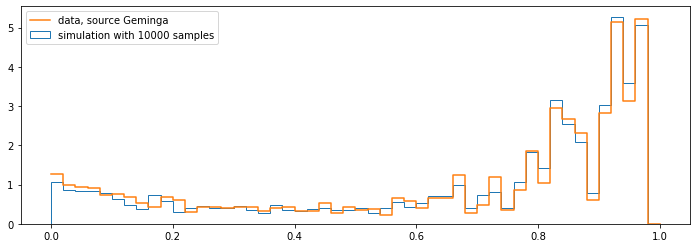

In [ ]:
#
from light_curves.weights import *
config = Config()
if config.valid:
    source = PointSource('Geminga')
    h = get_weight_hist(config, source)
    sf = _Sampler(h)
    data = sf(10000)
    fig,ax = plt.subplots(figsize=(12,4))
    ax.hist(data, np.linspace(0,1, len(h)+1), density=True, 
            label=f'simulation with {len(data)} samples');
    ax.step( np.linspace(0,1, len(h)+1) , np.concatenate([[h[0]], h])/np.sum(h)*len(h),
           label=f'data, source {source.name}');
    ax.legend();

In [ ]:
#export
class _WeightGenerator(_Sampler):
    """Generate a set of weights
    
    - `func` -- nominal weight distribution function, evaluated on (0,1)
    - `alpha, beta` -- (default 0,0). Values for $\\alpha$, $\\beta$.
    
    """
    def __init__(self, func, alpha=0, beta=0, n=100):
        if alpha==0 and beta==0:
            fprime = func
        else:
            # weight the function
            fprime = lambda w: func(w) * ( 1 + alpha*w + beta*(1-w) )
        super().__init__( fprime, limits=(0,1),  n=n)
  

In [ ]:

show_doc(_WeightGenerator, title_level=3)

<h3 id="_WeightGenerator" class="doc_header"><code>class</code> <code>_WeightGenerator</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>_WeightGenerator</code>(**`func`**, **`alpha`**=*`0`*, **`beta`**=*`0`*, **`n`**=*`100`*) :: `_Sampler`

Generate a set of weights

- `func` -- nominal weight distribution function, evaluated on (0,1)
- `alpha, beta` -- (default 0,0). Values for $\alpha$, $\beta$.

### Test  `_WeightGenerator`

In [ ]:
      
wg = _WeightGenerator(func)
test2 = wg.mean,  np.mean(wg(1000))
assert np.abs( test2[0]-test2[1] ) < 1e-1, f'Not almost equal: {test2}'

In [ ]:
#export
def generate_cell(wfun, mu, alpha=0, beta=0):
    """ Generate a cell

    - `wfun` -- weight function, or histogram. 
        Defined on (0,1)
    - `mu` -- number of expected weights, on average
    - `alpha`, `beta`  -- default 0,0; values for $\\alpha$ and  $\\beta$ for this cell 
    
    Returns a dict with:
    - `n` -- actual generated number of weights, from Poisson 
    - `w` -- array of weights 
    - `S, B` -- expected values for $\sum w$ and $\sum(1-w)$, calulated from wfun
    """
    from scipy import stats

    wgen_nominal = _WeightGenerator(wfun)
    wgen_cell =wgen_nominal if alpha==0 and beta==0 else _WeightGenerator(wfun, alpha, beta)
    
    # adjust expected number of events:
    wbar = wgen_nominal.mean
    mu_cell = mu * (1+alpha*wbar+beta*(1-wbar))
   
    # the weight array
    n = stats.poisson.rvs(mu_cell )    
    w = wgen_cell(n)
    
    S = wgen_nominal.mean * mu
    B = mu-S
    
    return dict(
        n=n,
        w=np.array(w, np.float32), #np.uint8),
        S=S,
        B=B,
    )

In [ ]:
show_doc(generate_cell)

<h4 id="generate_cell" class="doc_header"><code>generate_cell</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>generate_cell</code>(**`wfun`**, **`mu`**, **`alpha`**=*`0`*, **`beta`**=*`0`*)

Generate a cell

- `wfun` -- weight function, or histogram. 
    Defined on (0,1)
- `mu` -- number of expected weights, on average
- `alpha`, `beta`  -- default 0,0; values for $\alpha$ and  $\beta$ for this cell 

Returns a dict with:
- `n` -- actual generated number of weights, from Poisson 
- `w` -- array of weights 
- `S, B` -- expected values for $\sum w$ and $\sum(1-w)$, calulated from wfun

Test with a function peaked at both ends, generate equal signal and background

In [ ]:
#collapse_hide
def test_gen(alpha, beta, mu=10000, tol=3, quiet=True):
    wfun = lambda x: (x-0.5)**2
    pd.set_option('display.precision', 3)
    if not quiet: print(f'Test with alpha={alpha}, beta={beta}')
    cell = generate_cell( wfun, mu,  alpha, 0 if beta is None else beta)
    #
    ll = LogLike(cell); 
    if not quiet: print(f'Generated cell info:\n{ ll}')

    fit = ll.fit_info(beta is None )
    if not quiet: print(f'{2 if beta is not None else 1}-D fit info:\n{pd.Series(fit)}')
    t, sigt = fit['flux']-(1+alpha),  fit['sig_flux']
    check_alpha = '' if  np.abs(t)<tol*sigt else f'alpha: abs({t:.3f}) > {tol} * {sigt:.3f}'

    if beta is None:
        assert not bool(check_alpha), f'Failed: {check_alpha} '
    else:
        t, sigt = fit['beta']-beta, fit['sig_beta']
        check_beta ='' if np.abs(t)<tol*sigt else f'beta: abs({t:.3f}) > {tol} * {sigt:.3f}'

        assert not ( bool(check_alpha)  or bool(check_beta)), f'{check_alpha}  {check_beta}'
test_gen(0,None)
test_gen(10,None)
#test_gen(10, 0, tol=5, quiet=False)
test_gen(0,2)
test_gen(0.1, None, quiet=False)

Test with alpha=0.1, beta=None
Generated cell info:
light_curves.loglike.LogLike:  10547 weights, S 4998.5, B 5001.5
1-D fit info:
counts      10547.000
flux            1.117
sig_flux        0.017
dtype: float64


In [ ]:
#export
def generate_cells(config, source, wfun, source_flux):
    """
    
    - `source` -- a PointSource object, use to get exposure at its position
    - `wfun`   -- a weight function or histogram
    - `flux_fun` -- function of MJD time for the counts/day 

    """
    fexp, bins = get_binned_exposure(config, source)
    
    cells=[]
    for i, e in enumerate(fexp):
        a,b = bins[i:i+2]
        t, tw = (a+b)/2, b-a
        mu = source_flux(t)*tw *e

        cell = dict(t=t, tw=tw, e=e)
        cell.update(generate_cell(wfun, mu))

        cells.append(cell)
    return pd.DataFrame(cells)

In [ ]:
show_doc(generate_cells)

<h4 id="generate_cells" class="doc_header"><code>generate_cells</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>generate_cells</code>(**`config`**, **`source`**, **`wfun`**, **`source_flux`**)

- `source` -- a PointSource object, use to get exposure at its position
- `wfun`   -- a weight function or histogram
- `flux_fun` -- function of MJD time for the counts/day 

## Generate a set of poisson-like fits to the likelihoods

In [ ]:
#collapse-hide
config = Config()
def simulation_test():
    """
    ## Test the cell creation
    
    Generate {N} cells with the function {wfun}

    The "pulls"
    {fig1}
    
    A better measure of the shape is to evaluate the cumulative probability of the over-all mean
    for each likelihood function. This uses the `poisson.Poisson.cdf` function.
    {fig2}
    
    """
    
    wfun = lambda x: (x-0.5)**2
    mu = 100
    alpha = 2
    N = 10000
    def generate_cells(wfun, mu, alpha, N):
        return  [generate_cell( wfun, mu ,alpha) for i in range(N)]
    cells =  generate_cells(wfun, mu, alpha, N)

    pfits  = [PoissonRep(LogLike(cell )) for cell in cells]

    flux = np.array([p.flux for p in pfits]); 
    print(f'Flux: mean, std: {flux.mean():.3f}, {flux.std():.3f}')

    fmean = 1+alpha
    def pull(p):
        f, (l, h)  = p.flux, p.errors
        s = (h-l)/2
        return (f-fmean)/s
    pulls = np.array(list(map(pull, pfits)))
    print(f' pull: mean, std: {pulls.mean():.3f}, {pulls.std():.3f}')

    plt.rc('font', size=18)
    fig1,ax1 = plt.subplots(figsize=(4,3), num=1)
    ax1.hist(pulls, np.linspace(-5, 5, 21), lw=2, histtype='step', log=True);
    ax1.set(ylim=(0.8,None), xlabel='pull'); 
    ax1.grid(alpha=0.5)
    fig1.width=300

    class CDF():
        def __init__(self, alpha):
            self.f = 1+alpha
        def __call__(self, p):
            return p.poiss.cdf(self.f)
        
    def cdf(p, fmean=1.1):
        return p.poiss.cdf(fmean)

    #
    cd = np.array(list(map(CDF(alpha), pfits)))
    fig, ax = plt.subplots(figsize=(5,3), num=2)
    ax.hist(cd, np.linspace(0,1,21), histtype='step', lw=2)
    ax.set(xlabel='probability')
                            
    fig2 = figure(fig, width=300)
    return locals()

if config.valid:
    nbdoc(simulation_test)

Flux: mean, std: 3.003, 0.260
 pull: mean, std: -0.029, 1.005


## Test the cell creation

Generate 10000 cells with the function <function simulation_test.<locals>.<lambda> at 0x7f70a1d6c5f0>

The "pulls"
<div class="nbdoc_image">
<a href="images/simulation_test_fig_01.png"><figure style="margin-left: 5%">
   <img src="images/simulation_test_fig_01.png" alt="Figure 1 at images/simulation_test_fig_01.png" width=300> 
</figure></a></div>


A better measure of the shape is to evaluate the cumulative probability of the over-all mean
for each likelihood function. This uses the `poisson.Poisson.cdf` function.
<div class="nbdoc_image">
<a href="images/simulation_test_fig_03.png"><figure style="margin-left: 5%">
   <img src="images/simulation_test_fig_03.png" alt="Figure 3 at images/simulation_test_fig_03.png" width=300> 
</figure></a></div>



In [ ]:
#collapse-hide

def simulation_lightcurve_demo(source_name='Geminga'):
    """
    ### Lightcurve generation test
    
    This uses the exposure measured for the source {source_name}, and
    the default time bins to create a light curve assuming a fixed flux
    and a histogram of weights from the data.
    {output}
    
    {fig}
    """
    source = PointSource('Geminga')
    with capture_print('Print out') as output:
        whist = get_weight_hist(config, source)
        cells =  generate_cells(config, source, whist, 
                        source_flux=lambda t: 100)
        fits = fit_cells(config, cells)
        fig = figure(flux_plot(config, fits), width=500)
    
    return locals()

if config.valid:
    nbdoc(simulation_lightcurve_demo)

### Lightcurve generation test

This uses the exposure measured for the source Geminga, and
the default time bins to create a light curve assuming a fixed flux
and a histogram of weights from the data.
<details class="descripton" ><summary data-open="Hide " data-close="Show "> Print out </summary> <p style="margin-left: 5%"><pre>Weight histogram for Geminga: Restoring from cache with key "weight_hist_Geminga"<br>binned exposure for source Geminga: Restoring from cache with key "binned_exposure_Geminga"<br>Loaded 3873 / 4015 cells with exposure > 0.3 for fitting<br></pre></p> </details>

<div class="nbdoc_image">
<a href="images/simulation_lightcurve_demo_fig_01.png"><figure style="margin-left: 5%">
   <img src="images/simulation_lightcurve_demo_fig_01.png" alt="Figure 1 at images/simulation_lightcurve_demo_fig_01.png" width=500> 
</figure></a></div>



In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_gti.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cells.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 13_kerr_comparison.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_analysis.ipynb.
Converted index.ipynb.
Sun Dec 20 07:12:55 PST 2020
